# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2024. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import linregress
from dataclasses import dataclass
from math import sqrt,floor
from tueplots import bundles, fonts

In [ ]:
def law_function(x, alpha, beta, gamma):
    return alpha * np.exp(beta * x) + gamma

@dataclass
class GompertzMakeham:
    alpha: np.float64
    beta: np.float64
    gamma: np.float64

    def __init__(self, alpha, beta, gamma):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    @staticmethod
    def from_sequence(seq):
        return GompertzMakeham(alpha=seq[0], beta=seq[1], gamma=seq[2])

    def to_tuple(self):
        return (self.alpha, self.beta, self.gamma)

    def __str__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f}, gamma={self.gamma:.4f})'

    def __repr__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f}, gamma={self.gamma:.4f})'

In [2]:
# Constants for columns
DEATH_COLUMN = 'dead'
RUNNING_MORALITY_PERCENTAGE_COLUMN = 'cumulative deaths %'
PROBABILITY_OF_DEATH_PER_PERIOD_COLUMN = 'p(death per time period)'
AGE_IN_DAYS_COLUMN = 'age(days)'

# Human dataset columns
HUMAN_AGE_IN_YEARS_COLUMN = 'Age'
HUMAN_DEATHS_PER_YEAR_COLUMN = 'Total'

# Set here which groups from the ITP1 data set to plot. When PLOT_ALL_GROUP is False, the results will only be shown for the regarding GROUP_KEY. If PLOT_ALL_GROUP is True, the results will be shown for all interventions. Warning: The notebook will be very huge if PLOT_ALL_GROUP is True
GROUP_KEY = 'Control'
PLOT_ALL_GROUP = False

# Setting to set the y scale for the Gompertz-Makeham plots. Can be either log or linear scale.
USE_LOG = False

# time periods to bin mice by
# 13 was chosen because it is the fixed
# time period that made the data closest to having
# sqrt(dataset size) bins for the control group
mouse_bin_period_in_days = 13

days_per_years = 365

# tueplots settings
COL_STATE = 'full'  #Set to 'half' for the plot in the paper, 'full' for better analysis of the data
NROWS = 1
NCOLS = 1
USE_LATEX = False    #df: Somehow it doesn't work when USE_LATEX is True because "RuntimeError: Failed to process string with tex because latex could not be found". DIY

plt.rcParams.update(bundles.icml2022(column=COL_STATE, nrows=NROWS, ncols=NCOLS, usetex=USE_LATEX))

COLOR_MAP = ["#ADD8E6", "#008000", "#FFD700", "#800080", "#FF7F50", "#40E0D0", "#708090", "#FF8C00", "#FF00FF", "#008080"]

# Dataset Paths
HUMAN_LIFESPAN_DATASET_PATH = "../dat/final_datasets/Lifespans_Humans.xlsx"
MOUSE_LIFESPAN_DATASET_PATH = "../dat/final_datasets/Lifespans_ITP1.csv"

In [3]:
df = pd.read_csv(
    MOUSE_LIFESPAN_DATASET_PATH,
    skiprows=0,
    sep=";",
    index_col=[0, 1],
    skipfooter=0,
    engine="python",
    decimal=".",
)
df

site sex       id     group Rx(ppm)  age_initiation(mo)  \
population cohort                                                           
UM-HET3    C2004   TJL   m  JL00005  4-OH-PBN   315.0                   4   
           C2004   TJL   m  JL00006  4-OH-PBN   315.0                   4   
           C2004   TJL   m  JL00007  4-OH-PBN   315.0                   4   
           C2004   TJL   f  JL00095  4-OH-PBN   315.0                   4   
           C2004   TJL   f  JL00096  4-OH-PBN   315.0                   4   
...                ...  ..      ...       ...     ...                 ...   
           C2017    UT   m  UT10744       Syr   300.0                   5   
           C2017    UT   m  UT10745       Syr   300.0                   5   
           C2017    UT   m  UT10783       Syr   300.0                   5   
           C2017    UT   m  UT10784       Syr   300.0                   5   
           C2017    UT   m  UT10785       Syr   300.0                   5   

                  status  dead  age(days)  
population cohort                          
UM-HET3    C2004    dead     1        896  
           C2004    dead     1       1077  
           C2004    dead     1        790  
           C2004    dead     1        823  
           C2004    dead     1        601  
...                  ...   ...        ...  
           C2017    dead     1        289  
           C2017    dead     1        662  
           C2017    dead     1        440  
           C2017    dead     1        342  
           C2017    dead     1        754  

[26993 rows x 9 columns]

In [4]:
# Split dataset into intervention datasets
# Here we put either all groups in the set or only the one group with the specified GROUP_KEY. Depends on the settings

experiment_names = df['group'].unique()

experiment_groups = {}
for experiment_name in experiment_names:
    if PLOT_ALL_GROUP:
        experiment_group = df.loc[df['group'] == experiment_name].copy()
        experiment_group = experiment_group.sort_values(by=[AGE_IN_DAYS_COLUMN]).copy()
        
        # ignore experiment groups with not enough data
        if len(experiment_group) > 1:
            experiment_groups[experiment_name] = experiment_group
    elif experiment_name == GROUP_KEY:
        experiment_group = df.loc[df['group'] == experiment_name].copy()
        experiment_group = experiment_group.sort_values(by=[AGE_IN_DAYS_COLUMN]).copy()
        
        # ignore experiment groups with not enough data
        if len(experiment_group) > 1:
            experiment_groups[experiment_name] = experiment_group

def map_over_experiments(experiment_groups, fn, *args):
    return {name: fn(data, *args) for name, data in experiment_groups.items()}

# Mouse Dataset Preprocessing (Bucketing)
Here we bucket (or group) deaths in the mouse dataset into a bucket of a certain fixed time range (e.g. death in 0-9 days, 10-19 days, 20-29 days, etc.). We do this as the deaths are currently recorded as they occur which can occur at any length of time, thereby making the data less easily intepretable and less compatable with most human dataset

In [5]:
def group_same_ages(data) -> pd.DataFrame:
    return data.groupby(AGE_IN_DAYS_COLUMN).sum()

def group_ages(data: pd.DataFrame, bin_period_in_days: int) -> pd.DataFrame:
    data = data[[DEATH_COLUMN, AGE_IN_DAYS_COLUMN]]

    data = group_same_ages(data)

    group_days_by_time_period = lambda x: (x // bin_period_in_days)
    groupped_data_by_time_period = data.groupby(group_days_by_time_period).sum()

    index_name = f'age(per {bin_period_in_days} days)'
    groupped_data_by_time_period.index.name = index_name
    return groupped_data_by_time_period


experiment_dead_counts = map_over_experiments(experiment_groups, group_ages, mouse_bin_period_in_days)
experiment_dead_counts[GROUP_KEY]

,dead
age(per 13 days),
2,1
3,2
4,1
5,0
6,2
...,...
102,2
103,2
104,2


# Mouse Dataset Preprocessing (Mortality Rate per Time Period)

We follow this with computing the chance of death with a time period range. As an example, if there were 1,000 mice alive at *day 100* and 900 left at 110 days (with 10 being the bucket size of the histogram), then (1,000 - 900) / 1,000 = 10% would be the calculated chance of death. This ignores how many mice were alive initially at the start of the experiment for that particular calculation.

In [6]:
def calculate_running_alive_counts(data: pd.DataFrame) -> pd.DataFrame:
    total = calculate_total(data)
    running_alive = total - data.cumsum()

    # Start dataset with all alive and drop the last column to maintain same
    # shape as before
    running_alive.index += 1
    running_alive = pd.concat([pd.DataFrame([total]), running_alive])[:-1]

    return running_alive

def calculate_total(data: pd.DataFrame) -> pd.DataFrame:
    return data.sum()

def compute_chance_of_death_per_time_period(dead_counts: pd.DataFrame,
                                            running_alive_counts: pd.DataFrame) -> pd.DataFrame:
    return dead_counts / (running_alive_counts + 1e-9)

def fill_chance_per_time_period(chance_of_death: pd.DataFrame) -> pd.DataFrame:
    last_value = None
    for row in chance_of_death.iterrows():
        if np.isnan(row[1]['dead']):
            if last_value is None:
                last_value = 0
            chance_of_death['dead'][row[0]] = last_value
        else:
            last_value = row[1]['dead']
    return chance_of_death


running_alive_counts = map_over_experiments(experiment_dead_counts, calculate_running_alive_counts)

chance_of_death_per_experiment = {}
for experiment_name in experiment_dead_counts.keys():
    dead_counts = experiment_dead_counts[experiment_name]
    alive_counts = running_alive_counts[experiment_name]
    
    chance_of_death = compute_chance_of_death_per_time_period(dead_counts, alive_counts)
    
    # We dont have enough data points for each time period -> some time periods have NaNs -> We fill these values with the first non NaN left of it
    #chance_of_death = fill_chance_per_time_period(chance_of_death)
    
    chance_of_death_per_experiment[experiment_name] = chance_of_death


chance_of_death_per_experiment[GROUP_KEY]

,dead
0,NaN
2,NaN
3,0.000272
4,0.000136
5,0.000000
...,...
104,0.500000
105,NaN
107,NaN
108,NaN


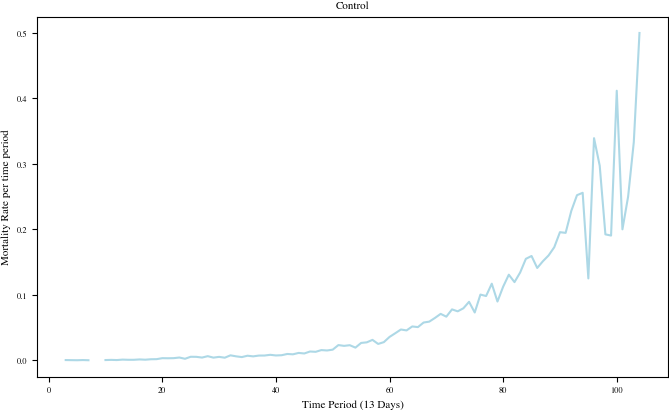

In [7]:
def graph_chance_of_death_per_time_period(chance_of_death_per_time_period: pd.DataFrame,
                                          time_period_in_days: int,
                                          title: str) -> None:
    fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS)
    ax.plot(chance_of_death_per_time_period, color=COLOR_MAP[0])
    ax.set_xlabel(f'Time Period ({time_period_in_days} Days)')
    ax.set_ylabel(f'Mortality Rate per time period')
    ax.set_title(title)


for group_name in chance_of_death_per_experiment.keys():
    graph_chance_of_death_per_time_period(chance_of_death_per_experiment[group_name], mouse_bin_period_in_days, group_name)

# Mouse Dataset Preprocessing (Cumulative Mortality Rate)

In contrast with the mortality rate per time period, here we consider the morality rate with respect to the initial population size. As an example, if there were 1,000 mice alive at *the start of the experiment* and 900 left at 110 days, then (1,000 - 900) / 1,000 = 10% would be the calculated chance of death. This ignores how many mice were alive initially at the start of the experiment for that particular calculation.

In [8]:
def calculate_cumulative_deaths(data):
    return data[DEATH_COLUMN].cumsum()

def compute_total_deaths(cumulative_deaths):
    return cumulative_deaths.iloc[-1]

def compute_running_mortality_percentage(data):
    cumulative_deaths = calculate_cumulative_deaths(data)
    total_deaths = compute_total_deaths(cumulative_deaths)

    if total_deaths == 0:
        raise ValueError('Invalid dataset (# of deaths must be > 0)')

    return cumulative_deaths / total_deaths

#running_mortality_percentage = compute_running_mortality_percentage(control_group)
#control_group.loc[:, RUNNING_MORALITY_PERCENTAGE_COLUMN] = running_mortality_percentage
#control_group[[AGE_IN_DAYS_COLUMN, RUNNING_MORALITY_PERCENTAGE_COLUMN]]


running_mortality_percentage = map_over_experiments(experiment_groups, compute_running_mortality_percentage)

for experiment_name in experiment_groups.keys():
    experiment_groups[experiment_name].loc[:, RUNNING_MORALITY_PERCENTAGE_COLUMN] = running_mortality_percentage[experiment_name]

experiment_groups[GROUP_KEY][[AGE_IN_DAYS_COLUMN, RUNNING_MORALITY_PERCENTAGE_COLUMN]]

age(days)  cumulative deaths %
population cohort                                
UM-HET3    C2005          27             0.000000
           C2004          27             0.000136
           C2005          27             0.000136
           C2005          29             0.000136
           C2005          29             0.000136
...                      ...                  ...
           C2007        1340             0.999457
           C2014        1358             0.999593
           C2007        1359             0.999728
           C2015        1396             0.999864
           C2011        1456             1.000000

[7815 rows x 2 columns]

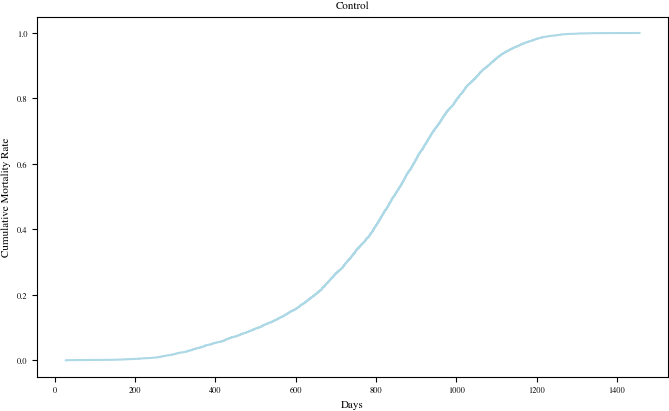

In [9]:
def graph_running_mortality_percentage(age_in_days: pd.DataFrame,
                                       running_mortality_percentage: pd.DataFrame,
                                       title: str) -> None:
    plt.plot(age_in_days, running_mortality_percentage, color=COLOR_MAP[0])
    plt.xlabel('Days')
    plt.ylabel('Cumulative Mortality Rate')
    plt.title(title)
    plt.show()

for experiment_name, experiment_group in experiment_groups.items():
    age_in_days = experiment_group.loc[:, AGE_IN_DAYS_COLUMN]
    running_mortality_rate = experiment_group.loc[:, RUNNING_MORALITY_PERCENTAGE_COLUMN]
    graph_running_mortality_percentage(age_in_days, running_mortality_rate, title=experiment_name)

# Gompertz Model

We use a Gompertz curve to fit the data with the assumption it follows the Gompertz-Makeham Law of Mortality. Refer to the link below for more details: [Gompertz–Makeham law of mortality](https://en.wikipedia.org/wiki/Gompertz%E2%80%93Makeham_law_of_mortality)

In [10]:
def fit_gompertz_model(gompertz_makeham: GompertzMakeham,
                       ages: pd.DataFrame,
                       mortality_rate: pd.DataFrame,
                       max_fit_iterations: int = 2500) -> GompertzMakeham:
    initial_parameters = gompertz_makeham.to_tuple()
    predicted_parameters, covariance = curve_fit(law_function, ages, mortality_rate, p0=initial_parameters, maxfev=max_fit_iterations)
    return GompertzMakeham.from_sequence(predicted_parameters)

# Mortality Graphs

In [11]:
def population_at_daystart(data: pd.DataFrame) -> pd.DataFrame:
    total_population = calculate_total(data)
    population_at_start_of_day = (total_population) - data.cumsum()
    population_at_start_of_day = population_at_start_of_day.shift(1)
    population_at_start_of_day.loc[population_at_start_of_day.index.values[0]] = total_population
    return population_at_start_of_day.rename(columns={"dead": "Population"})

def calculate_mortality_rates(dead_counts: pd.DataFrame, population_data: pd.DataFrame) -> pd.DataFrame:
    return dead_counts['dead'] / population_data['Population']

def remove_days_without_deaths(data: pd.DataFrame) -> pd.DataFrame:
    return data[(data[["dead"]] != 0).all(axis=1)]

def graph_mortality_rate(experiment_group: pd.DataFrame, time_period_in_days: int, title: str):
    dead_counts = remove_days_without_deaths(group_ages(experiment_group, time_period_in_days))
    population_data = population_at_daystart(dead_counts)
    mortality_rate = calculate_mortality_rates(dead_counts, population_data)
    if USE_LOG:
        mortality_rate.apply(lambda x: np.log(x)).plot(style='.', color=COLOR_MAP[0])
        plt.ylabel("Log Mortality Rate")
        plt.title(f"Log Mortality Rate ({title})")
    else:
        mortality_rate.plot(style='.', color=COLOR_MAP[0])
        plt.ylabel("Mortality Rate")
        plt.title(f"Mortality Rate ({title})")
    plt.xlabel("Age")
    plt.show()

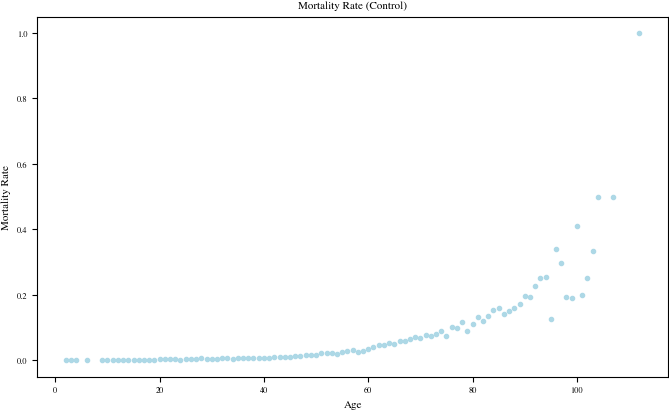

In [12]:
for experiment_name, experiment_group in experiment_groups.items():
    graph_mortality_rate(experiment_group, mouse_bin_period_in_days, experiment_name)

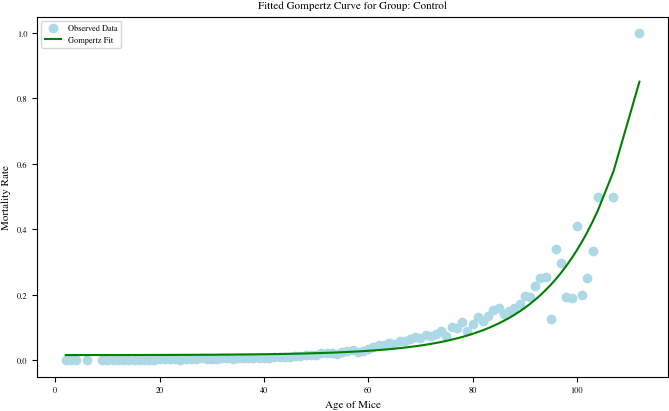

Fitted Parameters:
Alpha: 0.00010909973371448962
Beta: 0.07985347881622741
Gamma: 0.01583196004998197


Statistics:
R-squared: 0.9133917092492903
Mean Squared Error: 0.0017016448982363434


In [13]:
@dataclass
class ExperimentSample:
    ages: pd.DataFrame
    mortality_rate: pd.DataFrame

def compute_experiment_sample(experiment_group: pd.DataFrame, bin_period_in_days: int) -> None:
    dead_counts = remove_days_without_deaths(group_ages(experiment_group, bin_period_in_days))
    population_data = population_at_daystart(dead_counts)

    ages = dead_counts.index
    mortality_rate = calculate_mortality_rates(dead_counts, population_data)

    return ExperimentSample(ages=ages, mortality_rate=mortality_rate)

def fit_gompertz_from_experiment(experiment_sample: ExperimentSample, gompertz_makeham: GompertzMakeham) -> None:
    ages = experiment_sample.ages
    mortality_rate = experiment_sample.mortality_rate

    predicted_parameters = fit_gompertz_model(gompertz_makeham, ages, mortality_rate)
    predicted_mortality = law_function(ages, predicted_parameters.alpha, predicted_parameters.beta, predicted_parameters.gamma)

    return predicted_parameters, predicted_mortality

def plot_fitted_gompertz_curve(experiment_sample: ExperimentSample, predicted_mortality: pd.DataFrame, title: str) -> None:
    ages = experiment_sample.ages
    mortality_rate = experiment_sample.mortality_rate
    log_mortality_rate = mortality_rate.apply(lambda x: np.log(x))
    log_predicted_mortality = np.log(predicted_mortality)

    # Plot the results
    if USE_LOG:
        plt.scatter(ages, log_mortality_rate, label='Observed Data', color=COLOR_MAP[0])
        plt.plot(ages, log_predicted_mortality, label='Gompertz Fit', color=COLOR_MAP[1])
    else:
        plt.scatter(ages, mortality_rate, label='Observed Data', color=COLOR_MAP[0])
        plt.plot(ages, predicted_mortality, label='Gompertz Fit', color=COLOR_MAP[1])
    
    plt.xlabel('Age of Mice')
    plt.ylabel(f'Mortality Rate')
    plt.legend()
    plt.title(f'Fitted Gompertz Curve for Group: {title}')
    plt.show()


for experiment_name, experiment_group in experiment_groups.items():
    initial_parameters = GompertzMakeham(alpha=0.1, beta=0.085, gamma=0.01)

    experiment_sample = compute_experiment_sample(experiment_group, mouse_bin_period_in_days)
    parameters, predicted_mortality = fit_gompertz_from_experiment(experiment_sample, initial_parameters)
    plot_fitted_gompertz_curve(experiment_sample, predicted_mortality, experiment_name)

    print('Fitted Parameters:')
    print("Alpha:", parameters.alpha)
    print("Beta:", parameters.beta)
    print("Gamma:", parameters.gamma)

    print('\n')

    mortality_rate = experiment_sample.mortality_rate
    r_squared = r2_score(mortality_rate, predicted_mortality)
    mse = mean_squared_error(mortality_rate, predicted_mortality)

    print('Statistics:')
    print(f'R-squared: {r_squared}')
    print(f'Mean Squared Error: {mse}')
    print('\n')

# Human Data

Here we do some basic preprocessing to compute interesting statistics and also create the columns that are used in the mouse dataset. One small, but important fact worth mentioning is that the dataset is already binned by year which we multiply by 365 to get the number of days in which the data in binned.

#### Potential Future Improvements
We are currently ignoring leap years as we expect them to have little effect on the outcome, however including them as a fact could be considered a future improvement.

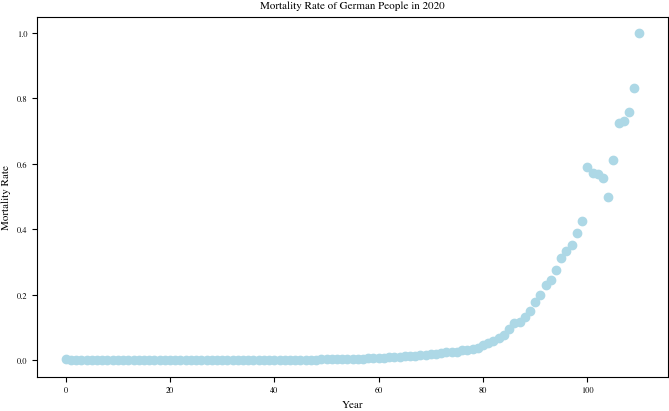

In [14]:
## Import  Human Data
human_mortality_df = pd.read_excel(HUMAN_LIFESPAN_DATASET_PATH)
human_mortality_df

human_mortality_df['MortalityRate'] = human_mortality_df['Total'] / human_mortality_df['Population']
human_mortality_df['LogMortalityRate'] = human_mortality_df['MortalityRate'].apply(lambda x: np.log(x))

# Add columns expected by bootstrap methods
human_mortality_df[[AGE_IN_DAYS_COLUMN]] = human_mortality_df[[HUMAN_AGE_IN_YEARS_COLUMN]] * days_per_years
human_mortality_df[[DEATH_COLUMN]] = human_mortality_df[[HUMAN_DEATHS_PER_YEAR_COLUMN]]

if USE_LOG:
    plt.scatter(human_mortality_df['Age'], human_mortality_df['LogMortalityRate'], color=COLOR_MAP[0])
    plt.ylabel('Log Mortality Rate')
    plt.title('Log Mortality Rate of German People in 2020')
else:
    plt.scatter(human_mortality_df['Age'], human_mortality_df['MortalityRate'], color=COLOR_MAP[0])
    plt.ylabel('Mortality Rate')
    plt.title('Mortality Rate of German People in 2020')
plt.xlabel('Year')
plt.show()

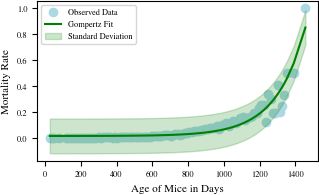

Fitted Parameters for Human:
Alpha: 0.00014200889745552624
Beta: 0.08031015701722538
Gamma: -0.007863598177121976
R-squared: 0.9833115896493789
Mean Squared Error: 0.000759431823911743

Fitted Parameters for Control:
Alpha: 0.00010909973371448962
Beta: 0.07985347881622741
Gamma: 0.01583196004998197
R-squared: 0.9133917092492903
Mean Squared Error: 0.0017016448982363434


In [24]:
# Fit Human Data to Gompertz
ages = human_mortality_df['Age']
mortality_rates = human_mortality_df['MortalityRate']
log_mortality_rates = mortality_rates.apply(lambda x: np.log(x))
human_samples = ExperimentSample(ages=ages, mortality_rate=mortality_rates)

human_initial_gompertz_parameters = GompertzMakeham(alpha=0.1, beta=0.085, gamma=0.01)
predicted_parameters, predicted_mortality = fit_gompertz_from_experiment(human_samples, human_initial_gompertz_parameters)

predicted_mortality = law_function(ages, predicted_parameters.alpha, predicted_parameters.beta, predicted_parameters.gamma)

# Fit control group data to Gompertz
group_control = experiment_groups['Control']
initial_parameters_control = GompertzMakeham(alpha=0.1, beta=0.085, gamma=0.01)

sample_control = compute_experiment_sample(group_control, mouse_bin_period_in_days)
parameters_control, predicted_mortality_control = fit_gompertz_from_experiment(sample_control, initial_parameters_control)

ages_control = [x * mouse_bin_period_in_days for x in sample_control.ages]
mortality_rate_control = sample_control.mortality_rate

# Plot the human results
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=USE_LATEX))
fig, ax = plt.subplots(nrows=1, ncols=1)
# 
# if USE_LOG:
#     log_predicted_mortality = np.log(predicted_mortality)
#     log_mortality_std_dev = np.std(log_predicted_mortality)
#     ax1.scatter(ages, log_mortality_rates, label='Observed Data', color=COLOR_MAP[0])
#     ax1.plot(ages, log_predicted_mortality, label='Gompertz Fit', color=COLOR_MAP[1])
#     ax1.fill_between(ages, log_predicted_mortality - log_mortality_std_dev, log_predicted_mortality + log_mortality_std_dev, label='Standard Deviation', color=COLOR_MAP[1], alpha=0.2)
# else:
#     mortality_std_dev = np.std(predicted_mortality)
#     ax1.scatter(ages, mortality_rates, label='Observed Data', color=COLOR_MAP[0])
#     ax1.plot(ages, predicted_mortality, label='Gompertz Fit', color=COLOR_MAP[1])
#     ax1.fill_between(ages, predicted_mortality - mortality_std_dev, predicted_mortality + mortality_std_dev, label='Standard Deviation', color=COLOR_MAP[1], alpha=0.2)
# ax1.set_xlabel('Age of Humans in Years')
# ax1.set_ylabel('Mortality Rate')
# fig.suptitle(f'Gompertz-Makeham Fitting {GROUP_KEY} Group')
# ax1.legend()

# Plot the control group results
if USE_LOG:
    log_mortality_rate_control = mortality_rate_control.apply(lambda x: np.log(x))
    log_predicted_mortality_control = np.log(predicted_mortality_control)
    log_mortality_std_dev_control = np.std(log_predicted_mortality_control)
    ax.scatter(ages_control, log_mortality_rate_control, label='Observed Data', color=COLOR_MAP[0])
    ax.plot(ages_control, log_predicted_mortality_control, label='Gompertz Fit', color=COLOR_MAP[1])
    ax.fill_between(ages_control, log_predicted_mortality_control - log_mortality_std_dev_control, log_predicted_mortality_control + log_mortality_std_dev_control, label='Standard Deviation', color=COLOR_MAP[1], alpha=0.2)
else:
    mortality_std_dev_control = np.std(predicted_mortality_control)
    ax.scatter(ages_control, mortality_rate_control, label='Observed Data', color=COLOR_MAP[0])
    ax.plot(ages_control, predicted_mortality_control, label='Gompertz Fit', color=COLOR_MAP[1])
    ax.fill_between(ages_control, predicted_mortality_control - mortality_std_dev_control, predicted_mortality_control + mortality_std_dev_control, label='Standard Deviation', color=COLOR_MAP[1], alpha=0.2)
ax.set_xlabel('Age of Mice in Days')
ax.set_ylabel(f'Mortality Rate')
ax.legend()

# We will save this plot if there is only 1 group to plot
if PLOT_ALL_GROUP == False:
    fig.savefig('../fig/2401_001_gompertz_' + GROUP_KEY + '.pdf')

plt.show()

print("Fitted Parameters for Human:")
print("Alpha:", predicted_parameters.alpha)
print("Beta:", predicted_parameters.beta)
print("Gamma:", predicted_parameters.gamma)

r_squared = None
mse = None
if USE_LOG:
    r_squared = r2_score(log_mortality_rates, log_predicted_mortality)
    mse = mean_squared_error(log_mortality_rates, log_predicted_mortality)
else:
    r_squared = r2_score(mortality_rates, predicted_mortality)
    mse = mean_squared_error(mortality_rates, predicted_mortality)
print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')
print()

print(f"Fitted Parameters for {GROUP_KEY}:")
print("Alpha:", parameters_control.alpha)
print("Beta:", parameters_control.beta)
print("Gamma:", parameters_control.gamma)

r_squared = None
mse = None
if USE_LOG:
    r_squared = r2_score(log_mortality_rate_control, log_predicted_mortality_control)
    mse = mean_squared_error(log_mortality_rate_control, log_predicted_mortality_control)
else:
    r_squared = r2_score(mortality_rate_control, predicted_mortality_control)
    mse = mean_squared_error(mortality_rate_control, predicted_mortality_control)
print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')



In [ ]:
@dataclass
class BootstrapSetup:
    dataset: pd.DataFrame
    dataset_bin_period: int
    initial_parameters: GompertzMakeham
    sample_percentage: float

def create_bootstrap_sample(df: pd.DataFrame, sample_percentage: int) -> pd.DataFrame:
    n_samples = int(len(df) * sample_percentage)
    indices = np.random.randint(low=0, high=len(df), size=n_samples)
    return df.iloc[indices]

def bootstrap_gompertz_parameters_once(setup: BootstrapSetup) -> GompertzMakeham:
    bootstrap_sample = create_bootstrap_sample(setup.dataset, setup.sample_percentage)
    bootstrap_experiment_sample = compute_experiment_sample(bootstrap_sample, setup.dataset_bin_period)
    parameters, _ = fit_gompertz_from_experiment(bootstrap_experiment_sample, setup.initial_parameters)
    return parameters

def bootstrap_gompertz_parameters(setup: BootstrapSetup, n_trials: int):
    parameters_list = []
    for _ in range(n_trials):
        parameters = bootstrap_gompertz_parameters_once(setup)
        parameters_list.append(parameters)
    return parameters_list

def calculate_parameter_statistics(gompertz_parameters: [GompertzMakeham]) -> GompertzMakeham:
    alphas = np.array([p.alpha for p in gompertz_parameters])
    betas = np.array([p.beta for p in gompertz_parameters])
    gammas = np.array([p.gamma for p in gompertz_parameters])

    parameter_mean = GompertzMakeham(alpha=alphas.mean(), beta=betas.mean(), gamma=gammas.mean())
    parameter_variance = GompertzMakeham(alpha=alphas.var(), beta=betas.var(), gamma=gammas.var())

    return parameter_mean, parameter_variance

# Measuring Parameter Variance
Here we select randomly with replacement (bootstrap) death occurrances from each dataset and then predict a gompertz curve for each sample subset. This is followed with measuring the mean and the variance of the fitted parameters of the Gompertz curve. The latter statistic is especially useful in measuring in rough terms how "Gompertz-like" the data is. In other words, with a large variance this implies that model is not robust or generalize well therefore the data is not gompertz like. On the other hand, if it has low variance this means that the Gompertz curve is likely a model for fitting the data.

In [ ]:
sample_percentage = 0.1

In [ ]:
for experiment_name, experiment_group in experiment_groups.items():
    initial_parameters = GompertzMakeham(alpha=0.1, beta=0.085, gamma=0.01)
    n_trials_mice = int(sqrt(len(experiment_group)))

    n_samples = int(len(experiment_group) * sample_percentage)
    mouse_bootstrap_setup = BootstrapSetup(experiment_group, dataset_bin_period=30, initial_parameters=initial_parameters,
                                            sample_percentage=sample_percentage)

    mouse_bootstrapped_parameters = bootstrap_gompertz_parameters(mouse_bootstrap_setup, n_trials=n_trials_mice)
    mouse_parameter_mean, mouse_parameter_variance = calculate_parameter_statistics(mouse_bootstrapped_parameters)

    print(f'Mouse Parameter Statistics ({experiment_name}):')
    print(f'mu = {mouse_parameter_mean}')
    print(f's^2 =  {mouse_parameter_variance}')
    print('\n')

In [ ]:
n_trials_humans = int(sqrt(len(human_mortality_df)))

# we set dataset_bin_period to 365 because the data has already been binned by the number of days in a years (365).
# Note: this ignore leap years, as it is assumed to be insigificant, but can be considered as a potential improvment.
human_bootstrap_setup = BootstrapSetup(human_mortality_df, dataset_bin_period=365, initial_parameters=initial_parameters,
                                       sample_percentage=sample_percentage)

human_bootstrapped_parameters = bootstrap_gompertz_parameters(human_bootstrap_setup, n_trials=n_trials_humans)
human_parameter_mean, human_parameter_variance = calculate_parameter_statistics(human_bootstrapped_parameters)

print(f'Human Parameter Statistics:')
print(f'mu = {human_parameter_mean}')
print(f's^2 =  {human_parameter_variance}')

# Mortality Analysis for Treatment Data

In [ ]:
def load_data_into_dicts(data_path,group_by_days=None):
    """
    Load CSV files from the specified path into male and female dictionaries.

    Parameters:
    - data_path (str): Path to the directory containing CSV files.

    Returns:
    - male_data (dict): Dictionary containing male data.
    - female_data (dict): Dictionary containing female data.
    """
    # Create empty dictionaries for male and female data
    male_data = {}
    female_data = {}

    # Iterate through all CSV files in the specified path
    for file_name in os.listdir(data_path):
        if file_name.endswith(".csv"):
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(os.path.join(data_path, file_name))

            # Extract the gender and treatment information from the file name
            gender, treatment = file_name.split("_")[0], "_".join(file_name.split("_")[1:])

            # Combine gender and treatment to form the dictionary key
            key = f"{gender}_{treatment[:-4]}"  # Removing the ".csv" extension from treatment
            
            # Round Ages
            df['x'] = df['x'].apply(lambda x: floor(x))
            
            # Round Survival Rate
            df['y'] = df['y'].apply(lambda x: round(x,2))

            # Calculate the "Population" at each day
            df['Population'] = df['y'].apply(lambda x: floor(50 * x))
            df = df.drop_duplicates(subset=['Population'])
            
            # Calculate the "Deaths" at each day
            df['Death'] = 50 - df['Population']
            df['Death'] = df['Death'] - df['Death'].shift(1)
            
            #remove "negative deaths" -> mistake in data gathering
            df = df[df['Death'] >= 0]

            if group_by_days:
                df['Age'] = (df['x'] // group_by_days) 
                df = df.groupby('Age').agg({'Death': 'sum', 'Population': 'min'}).reset_index()
            else:
                df['Age'] = df['x']
                
            # Calculate the Mortality Rates
            df['Mortality'] = df['Death'] / df['Population']
                
            # Check gender and store the DataFrame in the appropriate dictionary
            if gender.lower() == "male":
                male_data[key] = df
            elif gender.lower() == "female":
                female_data[key] = df
    return male_data, female_data

def plot_gender_mortality(data_dict, gender_label, plot_log_mortality = False, plot_linear_regression = False):
    if plot_log_mortality:
        for key, df in data_dict.items():
            log_mortality = np.log(df['Mortality'])
            scatter_plot = plt.scatter(df['Age'], log_mortality, label=f'{key.split("male_")[1]}', color=COLOR_MAP[0])
            
            if plot_linear_regression:
                # Calculate linear regression for log mortality
                slope, intercept, _, _, _ = linregress(df['Age'], log_mortality)
                linear_regression_line = slope * df['Age'] + intercept
                plt.plot(df['Age'], linear_regression_line, color=COLOR_MAP[1],
                         linestyle='dashed', linewidth=1,alpha=0.5)
            
        plt.title(str("Treatment Data - " + gender_label + " Log Mortality"))
        
    else:
        for key, df in data_dict.items():
            plt.scatter(df['Age'], df['Mortality'], label=f'{key.split("male_")[1]}')
        plt.title(str("Treatment Data - " + gender_label + " Mortality"))
            
    plt.xlabel('Age')
    plt.ylabel('Mortality Rate')
    
    # Move the legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

def fit_and_plot_gompertz(data_dict):
    for key, df in data_dict.items():
        ages = df['Age']
        mortality_rates = df['Mortality']

        # Fit Treatment Data to Gompertz
        treatment_samples = ExperimentSample(ages=ages, mortality_rate=mortality_rates)

        initial_gompertz_parameters = GompertzMakeham(alpha=0.1, beta=0.085, gamma=0.01)
        predicted_parameters, predicted_mortality = fit_gompertz_from_experiment(treatment_samples, initial_gompertz_parameters)

        # Predict mortality using the fitted parameters
        predicted_mortality = law_function(ages, predicted_parameters.alpha, predicted_parameters.beta, predicted_parameters.gamma)

        # Plot the results
        plt.scatter(ages, mortality_rates, label=f'{key} - Observed Data', color=COLOR_MAP[0])
        plt.plot(ages, predicted_mortality, label=f'{key} - Gompertz Fit', color=COLOR_MAP[1])
        plt.xlabel('Age of Mice (Days)')
        plt.ylabel('Mortality Rate')
        plt.legend()
        plt.show()

        # Display fitted parameters
        print(f"\nFitted Parameters for {key}:")
        print("Alpha:", predicted_parameters.alpha)
        print("Beta:", predicted_parameters.beta)
        print("Gamma:", predicted_parameters.gamma)

In [ ]:
data_path = "../dat/RMR_data/"
male_dict, female_dict = load_data_into_dicts(data_path, mouse_bin_period_in_days)
female_dict["female_None"]

In [ ]:
plot_gender_mortality(male_dict, 'Male')
plot_gender_mortality(female_dict, 'Female')

In [ ]:
plot_gender_mortality(male_dict, 'Male',plot_log_mortality=True)
plot_gender_mortality(female_dict, 'Female',plot_log_mortality=True, plot_linear_regression = True)

In [ ]:
fit_and_plot_gompertz(female_dict)

In [ ]:
fit_and_plot_gompertz(male_dict)